# Test Cyclone Detector

This notebook tests the training of a deep convolutional neural network (a resnet) to detect cyclones/hurricanes in global weather models. It combines the historical record of real cyclones with data-assimilated model output (reanalysis). I use ERA5 reanalysis and storm track records from NOAA. More information about the data and initial processing can be found in [my repository](https://github.com/markmbaum/cyclone-detection).

Detecting real cyclones is easy with satellite imagery. Detecting them in simulated climates, like our warmer future climate, is a challenging task. [Current techniques](https://www.gfdl.noaa.gov/tstorms/) use a set of ad-hoc thresholds and comparisons, but this is error-prone. Deep learning is probably a better approach. Convolutional networks, in particular, are an obvious choice.

The model has not been trained on the entire dataset yet. The testing and tinkering below was to decide how to arrange the input and target data; what architecture and hyperparameters to use; and to get the implemenetation correct before finally training on the past 20 years of data at 6-hourly intervals.

Below, the model learns a small training set very well and ultimately overfits, performing worse on a small validation set. It only "sees" a relatively limited set of cyclones.

It's hard to know, but I suspect training on the whole dataset (~40x larger) and scaling up the model will yield solid performance, but performance may ultimately be limited by the dataset. The definition of a cyclone/hurricane in storm record is somewhat arbitrary, so there are storms that resemble hurricanes but are not present in the storm record, and maybe vice versa.

I'd like to train on all the data but my GCP free credits are exhausted and I don't want to start paying for GPU time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import FalseNegatives, FalsePositives
from tensorflow.keras.callbacks import LearningRateScheduler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

A subset of the data is on my Google Drive for convenience. For testing, I use August through October in 2010, 2015, and 2020. These months represent hurricane season in the North Atlantic.

Inputs and  targets are stored conveniently as `npy` files in monthly blocks. After they're loaded, high-latitude data above/below about 64 degrees from the equator are removed. There are no cyclones at these latitudes. The original images are relatively large (720 x 1440 x 3) so it's important to take advantage of obvious ways to reduce their size and speed up training.

For each input, I created a target map of the same horizontal dimensions (720 x 1440) that is zero everywhere except the *single pixel* nearest any cyclones present in the record. See the [construction script](https://github.com/markmbaum/cyclone-detection/blob/main/scripts/construct_targets.py) for the code. These maps are stored effciently as integers and make it easy to keep track of cyclone locations, although they are not used directly for training (see below).

In [4]:
years = [2010, 2015, 2020]
months = range(8, 11)
datadir = 'drive/MyDrive/data/cyclone-data'

In [5]:
inputs = []
for year in years:
    for month in months:
        inputs.append( np.load(f'{datadir}/inputs/{year}_{month}_inputs.npy') )
        inputs[-1] = np.moveaxis(inputs[-1], 1, -1)
        inputs[-1] = inputs[-1][:,104:-105,...]

In [6]:
targets = []
for year in years:
    for month in months:
        targets.append( np.load(f'{datadir}/targets/{year}_{month}_target_maps.npz')['maps'] )
        targets[-1] = targets[-1][:,104:-105,...]

In [7]:
cyclones = np.concatenate(targets, axis=0).sum()
print(f'{cyclones} total cyclones')

926 total cyclones


## Standardize along Temporal Axis

This mainly removes the natural equator-to-pole gradient in temperature.

In [8]:
for i in range(len(inputs)):
    m = inputs[i].mean(axis=0)
    s = inputs[i].std(axis=0)
    inputs[i] = (inputs[i] - m)/s
    print(f'{i}) mean = {inputs[i].mean():g}\n   std  = {inputs[i].std():g}')

0) mean = -1.75154e-06
   std  = 1
1) mean = -3.85765e-06
   std  = 0.999999
2) mean = 1.56068e-06
   std  = 1
3) mean = 6.27091e-07
   std  = 1
4) mean = -3.13108e-08
   std  = 0.999999
5) mean = -2.65042e-06
   std  = 1
6) mean = 7.33992e-07
   std  = 1
7) mean = 2.37257e-06
   std  = 0.999999
8) mean = -4.34073e-06
   std  = 0.999999


## Split, Flip, Stack

Here the inputs/targets are split at the equator (where no cyclones cross). Then the southern half is reflected about the equator and stacked on the northern half. This reduces the size of each input image by another factor of two, taking advantage of the natural symmerty. 

**Note** that the vorticity in the southern hemisphere must have its sign flipped for consistency, because the rotation direction is reversed (cyclonic vs anti-cyclonic).

In [9]:
def split_flip_stack(x, negate_southern_channels=[]):
    north, south = np.split(x, 2, axis=1)
    south = np.flip(south, axis=1)
    for channel in negate_southern_channels:
        south[:,:,:,channel] *= -1
    x = np.concatenate([north, south], axis=0)
    return x

In [10]:
X = np.concatenate([split_flip_stack(input, [0]) for input in inputs], axis=0)
X.shape

(2208, 256, 1440, 3)

In [11]:
Y = np.concatenate(list(map(split_flip_stack, targets)), axis=0)
Y.shape

(2208, 256, 1440, 1)

In [12]:
print('fraction of inputs with cyclones = ', round((Y.sum(axis=(1,2,3)) == 1).sum() / Y.shape[0], 6))

fraction of inputs with cyclones =  0.178442


## Standardize Each Input/Image

Now each input image is centered and rescaled individually.

In [13]:
for i in range(len(X)):
    m = X[i,...].mean(axis=0)
    s = X[i,...].std(axis=0)
    X[i,...] = (X[i,...] - m)/s
print(f'global mean = {X.mean():g}, global std = {X.std():g}')

global mean = 1.67068e-10, global std = 0.999995


## Plot a few

Circles indicate the location of cyclones/hurricanes.

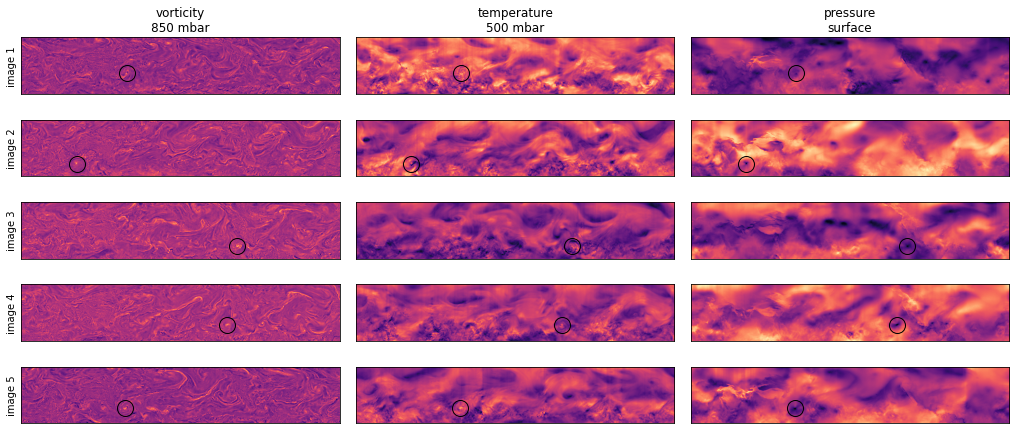

In [14]:
nimage = 5
fig, axs = plt.subplots(nimage, 3, figsize=(14,6), constrained_layout=True)
images = np.flatnonzero(Y.sum(axis=(1,2,3)) == 1)
np.random.shuffle(images)
images = images[:nimage]
for i,idx in enumerate(images):
    axs[i,0].imshow(X[idx,:,:,0], cmap='magma')
    axs[i,1].imshow(X[idx,:,:,1], cmap='magma')
    axs[i,2].imshow(X[idx,:,:,2], cmap='magma')
    axs[i,0].set_ylabel(f'image {i+1}')
    idx = np.argwhere(Y[idx,:,:,0])
    if len(idx) > 0:
        for j in range(idx.shape[0]):
            for ax in axs[i,:]:
                ax.plot(idx[j,1], idx[j,0], 'ko', markersize=16, markerfacecolor='none')
axs[0,0].set_title('vorticity\n850 mbar')
axs[0,1].set_title('temperature\n500 mbar')
axs[0,2].set_title('pressure\nsurface')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

## Subgrid Classification Targets

Here the targets are pooled to a lower-resolution grid of binary classification maps where 1 indicates the presence of a cyclone. This is similar to the standard approach in big object detection datasets. Here, however, the targets don't include information about bounding boxes or other regression, just the yes/no flag for each grid box.

In [15]:
#number of subgrid cells in each dimension
dy = 2**5
assert 256/dy == 256//dy
N = 256//dy
print(f'dy = {dy} pixels, N = {N} cells')

dx = 2**5
assert 1440/dx == 1440//dx
M = 1440//dx
print(f'dx = {dx} pixels, M = {M} cells')
M = int(M)

dy = 32 pixels, N = 8 cells
dx = 32 pixels, M = 45 cells


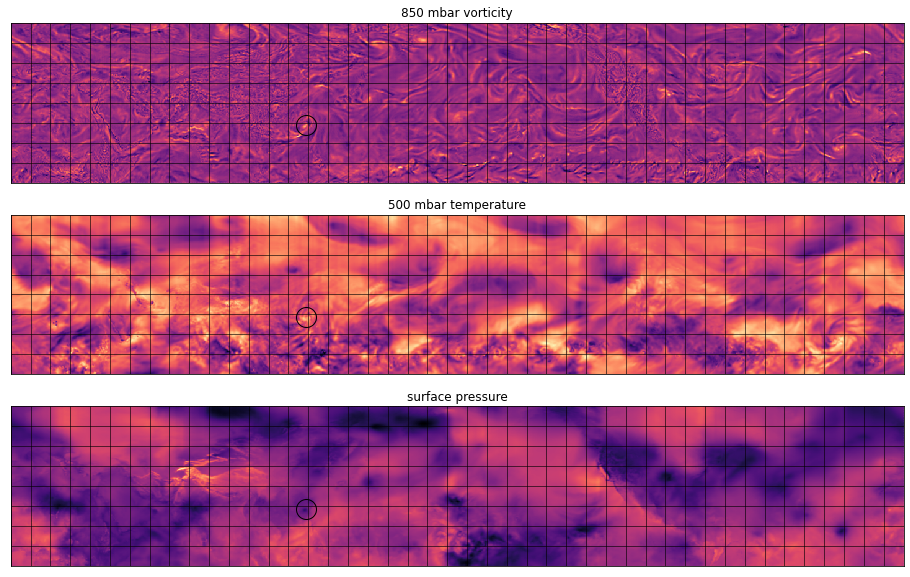

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(16,10))
for i,title in enumerate(['850 mbar vorticity', '500 mbar temperature', 'surface pressure']):
    axs[i].pcolormesh(X[images[0],::-1,:,i], cmap='magma', alpha=0.75)
    axs[i].hlines(range(0,256,dy), 0, 1440, linewidth=0.6, color='k')
    axs[i].vlines(range(0,1440,dx), 0, 256, linewidth=0.6, color='k')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(title)
idx = np.argwhere(Y[images[0],::-1,:,0])
for ax in axs:
    if len(idx) > 0:
        for j in range(idx.shape[0]):
            ax.plot(idx[j,1], idx[j,0], 'ko', markersize=20, markerfacecolor='none')

First pool by *summing*, to check how many cells contain multiple cyclones

In [17]:
classifications = np.zeros((Y.shape[0], N, M, 1), dtype=np.float32)
for i in range(N):
    for j in range(M):
        i1, i2 = i*dy, (i+1)*dy
        j1, j2 = j*dx, (j+1)*dx
        classifications[:,i,j,0] = Y[:,i1:i2,j1:j2,0].sum(axis=(1,2))
print(classifications.shape)
print('maximum count in grid cell:', classifications.max())

(2208, 8, 45, 1)
maximum count in grid cell: 1.0


None of them have multiple cyclones, so it's fine.

In [18]:
classifications = (classifications > 0).astype(np.float32)
print('maximum count in grid cell:', classifications.max())
classifications.shape

maximum count in grid cell: 1.0


(2208, 8, 45, 1)

Here I create regression grids indicating the horizontal and vertical offset of the cyclone location *within each cell*, scaled to [0,1].

I tinkered a little bit with modeling this regression in addition to the classification, like a more typical object detection model. But it adds a lot of complexity (custom loss function, metrics, etc.) and increases training time, so I decided not to include it. With more time & resources it's absolutely possible, though. One thing at a time. 🤷‍♀️

In [19]:
locations = np.zeros((Y.shape[0], N, M, 2), dtype=np.float32)
for k in range(locations.shape[0]):
    for i in range(N):
        for j in range(M):
            i1, i2 = i*dy, (i+1)*dy
            j1, j2 = j*dx, (j+1)*dx
            sl = Y[k,i1:i2,j1:j2,0]
            if np.any(sl > 0):
                assert sl.sum() <= 1
                idx = np.unravel_index(sl.argmax(), sl.shape)
                y = idx[0]/sl.shape[0]
                x = idx[1]/sl.shape[1]
                locations[k,i,j,:] = (x,y)
locations.shape

(2208, 8, 45, 2)

The following plot is just a check on the target classification/regression maps. The cyclone locations should clearly correspond to those in the first plot way above (and they do).

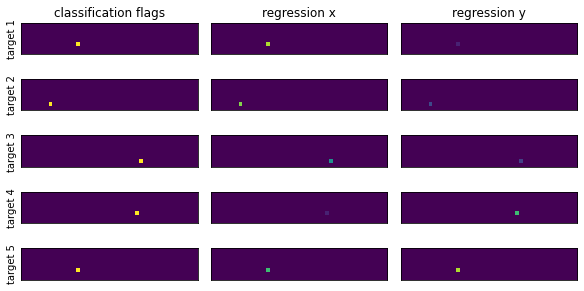

In [20]:
fig, axs = plt.subplots(nimage, 3, figsize=(8,4), constrained_layout=True)
for i,idx in enumerate(images):
    axs[i,0].imshow(classifications[idx,:,:,0])
    axs[i,1].imshow(locations[idx,:,:,0], vmax=1)
    axs[i,2].imshow(locations[idx,:,:,1], vmax=1)
    axs[i,0].set_ylabel(f'target {i+1}')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
axs[0,0].set_title('classification flags')
axs[0,1].set_title('regression x')
axs[0,2].set_title('regression y');

##  Batched Data Loaders


In [21]:
#small, easy to overload GPU memory
batch_size = 4
#training/validation split fraction
n = 4 * X.shape[0] // 5
#data loaders
train = Dataset.from_tensor_slices((X[:n], classifications[:n])).shuffle(n).batch(batch_size)
print(f'{Y[:n,:,:,0].sum()} nonzero classification targets in training set')
validate = Dataset.from_tensor_slices((X[n:], classifications[n:])).shuffle(n).batch(batch_size)
print(f'{Y[n:,:,:,0].sum()} nonzero classification targets in validation set')

773 nonzero classification targets in training set
153 nonzero classification targets in validation set


# Model Architecture

After experimenting with lots of different variations on convolutional architechtures, I settled on a fairly standard, fully-convolution (no dense layers) structure.

Mapping the input image of size 256 x 1440 x 3 to an 8 x 45 x 1 grid requires 5 halvings in the 0th and 1st dimensions. So, the model has 5 convolutional stages with maximum pooling in between each one. Each stage includes a number of residual blocks. After pooling, a non-residual convolutional layer is used to expand the channel depth for further processing.

All of the convolutional layers are batch normalized and leaky relu activated except the final layer, where a sigmoid is applied over the final grid for classification purposes.

I use the binary [focal loss](https://arxiv.org/abs/1708.02002), which should improve object detection performance with the very sparse output. In most places, almost all of the time, there isn't a cyclone present.

I also include droput after each pooling layer to discourage overfitting during training, but it happens anyway.

In [22]:
#creates a single, non-residual, convolutional block
#   filters - the number of filters/channels in the block
#   kernel_size - the "area" of the convolution kernel
#   alpha - negative slope coefficient in leaky relu layer
def conv_block(filters: int, kernel_size: int, alpha=0.1, name=None) -> Sequential:
    return Sequential(
        [
            Conv2D(filters, kernel_size, padding='same', use_bias=False),
            BatchNormalization(),
            LeakyReLU(alpha=alpha)
        ],
        name=name
    )

Below I implement the residual block layer, composed of two convolution sub-layers, as shown in the classic diagram below.

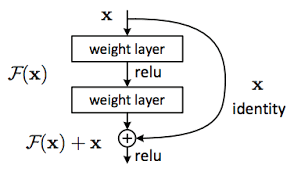

In [23]:
#creates a single residual block, which includes *two* convolutional layers, norms, and activations
#   filters - the number of filters/channels in the block
#   kernel_size - the "area" of the convolution kernel
#   alpha - negative slope coefficient in leaky relu layer
class ResidualBlock(Layer):

    def __init__(self, filters: int, kernel_size: int, alpha=0.1):
        super(ResidualBlock, self).__init__()
        self.block = Sequential([
            Conv2D(filters, kernel_size, padding='same', use_bias=False),
            BatchNormalization(),
            LeakyReLU(alpha=alpha),
            Conv2D(filters, kernel_size, padding='same', use_bias=False),
            BatchNormalization()
        ])
        self.activation = LeakyReLU(alpha=alpha)

    def build(self, shape):
        self.block.build(shape)
        self.activation.build(shape)

    def call(self, inputs):
        outputs = self.block(inputs)
        outputs += inputs
        return self.activation(outputs)

In [24]:
#forms a whole residual stage, stacking any number of residual blocks
#   filters - the number of filters/channels in each block
#   kernel_size - the "area" of the convolution kernel in each block
#   blocks - number of individual residual blocks to stack
#   alpha - negative slope coefficient in leaky relu layer
def residual_stage(filters: int, kernel_size: int, blocks: int, alpha=0.1, name=None) -> Sequential:
    assert blocks >= 1
    stage = []
    for _ in range(blocks):
        stage.append( ResidualBlock(filters, kernel_size, alpha) )
    return Sequential(stage, name=name)

In [25]:
#stacks together convolutional and residual blocks with 5 pooling layers and sigmoid output
#   channels - list of channels/depth of all 6 stages
#   kernels - list of kernel sizes for all 6 stages
#   blocks - list of number of residual blocks for all 6 stages
#   dropout - fractional dropout after each stage
#   alpha - negative slope coefficient in leaky relu layer
def cyclone_classifier(channels: list, kernels: list, blocks: list, dropout: float, alpha=0.1) -> Sequential:

    for params in (channels, kernels, blocks):
        assert type(params) is list and len(params) == 6

    model = []
    for i,(c,b,k) in enumerate(zip(channels, kernels, blocks)):
        model += [
            conv_block(c, k, alpha, f'conv_block_{i}_c{c}_k{k}'),
            residual_stage(c, k, b, alpha, f'residual_stage_{i}_c{c}_k{k}_b{b}')
        ]
        #final layer does not pool
        if i < 5:
            model += [
                MaxPool2D(),
                Dropout(dropout)
            ]

    model.append( Conv2D(1, 3, padding='same', activation='sigmoid', name='conv_head') )

    return Sequential(model, name='cyclone_classifier')

# Training

In [26]:
#too many channels can bust GPU memory, but could expand for final training
model = cyclone_classifier(
    [8, 16, 32, 64, 128, 64], #channels
    [7, 3, 3, 3, 3, 3], #kernel sizes
    [4, 4, 3, 3, 2, 2], #blocks per stage
    0.25 #dropout fraction after each stage
)

In [27]:
model.compile(
    optimizer='adam',
    loss=BinaryFocalCrossentropy(
        gamma=3, 
        from_logits=False
    ),
    metrics=[
        FalseNegatives(name='fal_neg'),
        FalsePositives(name='fal_pos')
    ]
)

In [28]:
#cyclical decaying function for the learning rate
schedule = lambda epoch, lr: max(1e-3 * np.exp(-epoch/6), 1e-7)

history = model.fit(
    train,
    validation_data=validate,
    epochs=24,
    callbacks=[LearningRateScheduler(schedule)],
    shuffle=True,
    verbose='auto'
)

Epoch 1/24
442/442 [==============================] - 308s 659ms/step - loss: 0.0027 - fal_neg: 682.0000 - fal_pos: 1235.0000 - val_loss: 5.1269e-04 - val_fal_neg: 99.0000 - val_fal_pos: 47.0000 - lr: 0.0010
Epoch 2/24
442/442 [==============================] - 294s 665ms/step - loss: 6.5713e-04 - fal_neg: 516.0000 - fal_pos: 247.0000 - val_loss: 8.8183e-04 - val_fal_neg: 153.0000 - val_fal_pos: 0.0000e+00 - lr: 8.4648e-04
Epoch 3/24
442/442 [==============================] - 294s 665ms/step - loss: 4.7775e-04 - fal_neg: 470.0000 - fal_pos: 217.0000 - val_loss: 7.2862e-04 - val_fal_neg: 147.0000 - val_fal_pos: 3.0000 - lr: 7.1653e-04
Epoch 4/24
442/442 [==============================] - 294s 666ms/step - loss: 4.0866e-04 - fal_neg: 413.0000 - fal_pos: 202.0000 - val_loss: 7.0462e-04 - val_fal_neg: 152.0000 - val_fal_pos: 0.0000e+00 - lr: 6.0653e-04
Epoch 5/24
442/442 [==============================] - 294s 666ms/step - loss: 3.7865e-04 - fal_neg: 390.0000 - fal_pos: 201.0000 - val_loss

In [29]:
model.summary()

Model: "cyclone_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_0_c8_k4 (Sequent  (None, 256, 1440, 8)     416       
 ial)                                                            
                                                                 
 residual_stage_0_c8_k4_b7 (  (None, 256, 1440, 8)     14784     
 Sequential)                                                     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 720, 8)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 720, 8)       0         
                                                                 
 conv_block_1_c16_k4 (Sequen  (None, 128, 720, 16)     2112      
 tial)                                          

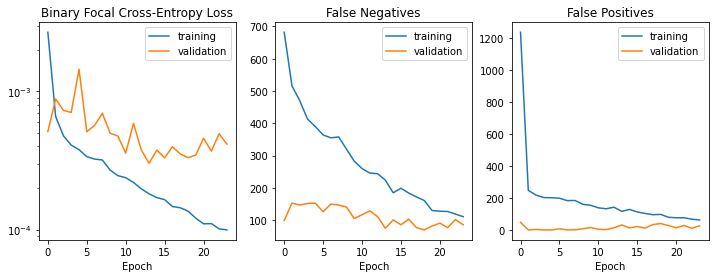

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].semilogy(history.history['loss'], label='training')
axs[0].semilogy(history.history['val_loss'], label='validation')
axs[0].set_title('Binary Focal Cross-Entropy Loss')
axs[0].legend()
axs[1].plot(history.history['fal_neg'], label='training')
axs[1].plot(history.history['val_fal_neg'], label='validation')
axs[1].set_title('False Negatives')
axs[1].legend()
axs[2].plot(history.history['fal_pos'], label='training')
axs[2].plot(history.history['val_fal_pos'], label='validation')
axs[2].set_title('False Positives')
axs[2].legend()
for ax in axs:
    ax.set_xlabel('Epoch')

This is a promising initial result for the small subset of training data. This relatively small model clearly has capacity to learn the classification function. Hopefully it will generalize well after training on the full dataset, but I don't know.

# Visualization

## Prediction Maps

Sample a few prediction maps and compare with corresponding target maps


In [31]:
L = 10
idx = np.flatnonzero(classifications.sum(axis=(1,2,3)))
idx = idx[np.random.randint(0, len(idx), L)]
preds = model(X[idx,...]).numpy().squeeze()
preds.shape

(10, 8, 45)

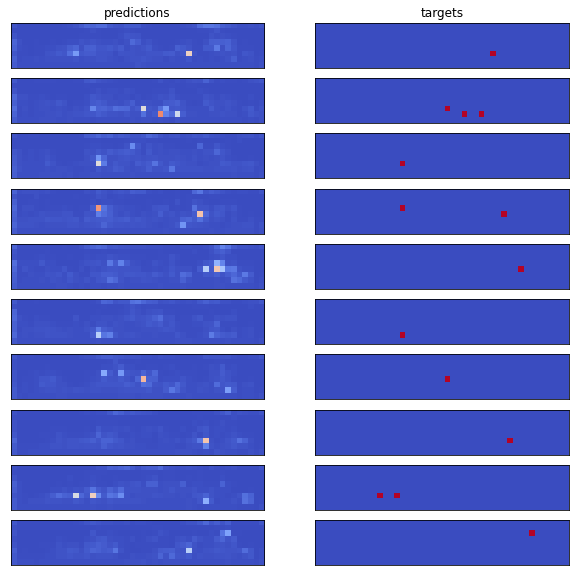

In [32]:
fig, axs = plt.subplots(L, 2, figsize=(10,L))
for i in range(L):
    r = axs[i,0].imshow(preds[i,...], vmin=0, vmax=1, cmap='coolwarm')
    r = axs[i,1].imshow(classifications[idx[i],...].squeeze(), vmin=0, vmax=1, cmap='coolwarm')
axs[0,0].set_title('predictions')
axs[0,1].set_title('targets')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

## Feature Maps

Here I plot the outputs after initial stages, before the channels are too numerous. The maps are hard to interpret clearly, but interesting to inspect.

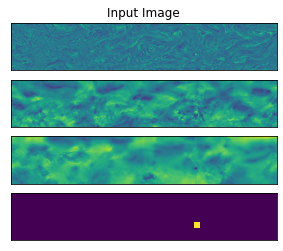

In [33]:
fig, axs = plt.subplots(4, 1, figsize=(8,4))
image = X[idx[0]:idx[0]+1,...]
for i,ax in enumerate(axs.flatten()[:3]):
    ax.imshow(image[0,:,:,i])
axs[-1].imshow(classifications[idx[0],:,:,0])
axs[0].set_title('Input Image')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [38]:
def feature_maps(model, nlayer, image):
    feat = Sequential(model.layers[:nlayer])(image)
    print(f'layer output shape = {feat.shape}')
    n = min(feat.shape[-1]//4, 8)
    fig, axs = plt.subplots(n, 4, figsize=(12,6*n/8), constrained_layout=True)
    for i,ax in enumerate(axs.flatten()):
        ax.imshow(feat[0,:,:,i], cmap='magma')
        ax.set_xticks([])
        ax.set_yticks([])
    return None

layer output shape = (1, 64, 360, 16)


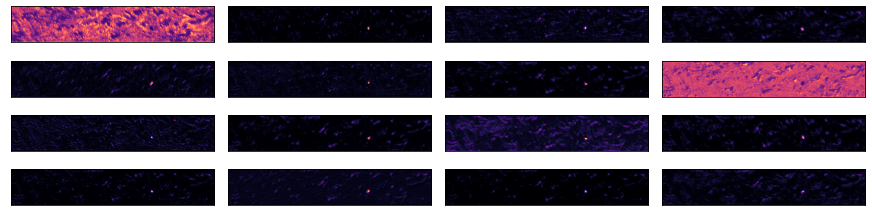

In [39]:
feature_maps(model, 7, image)

After the first block of processing and pooling, it's pretty clear where the cyclone is.

layer output shape = (1, 32, 180, 32)


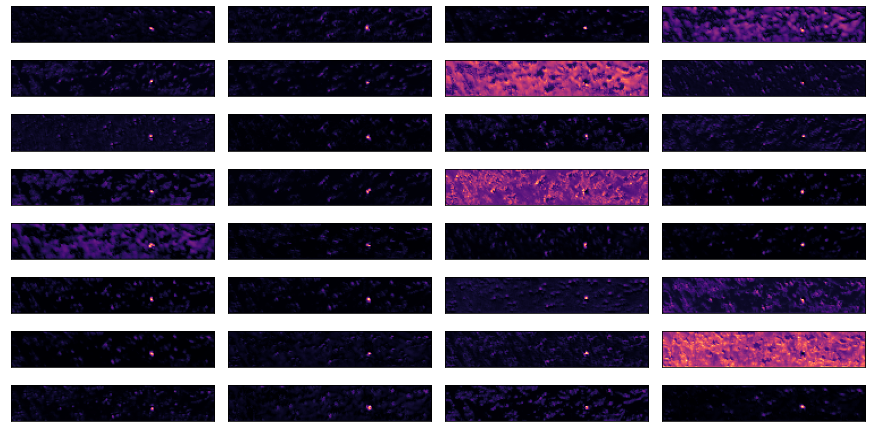

In [40]:
feature_maps(model, 11, image)

layer output shape = (1, 16, 90, 64)


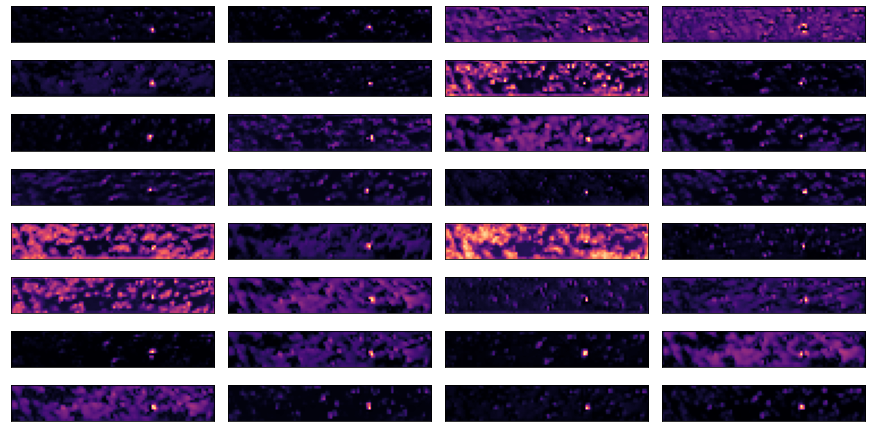

In [41]:
feature_maps(model, 15, image)

layer output shape = (1, 8, 45, 128)


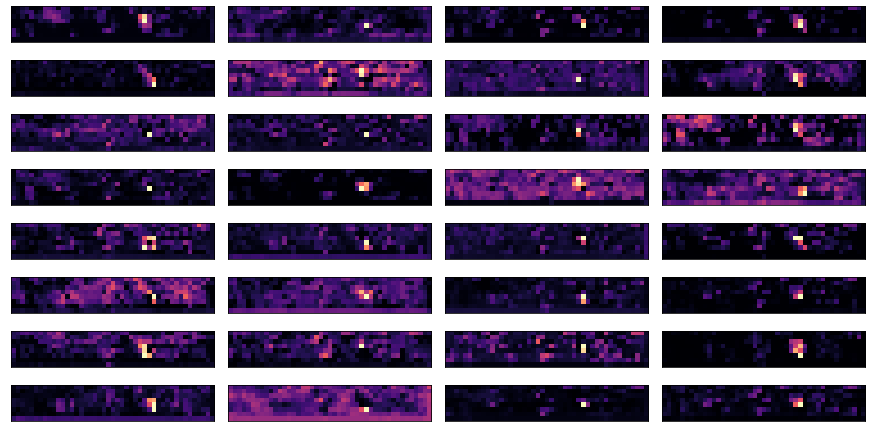

In [42]:
feature_maps(model, 19, image)